In [250]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.optimize as sop

## 1. Environment setting

In [188]:
# 2-armed bandit problem
T = 1000
k = 2
q_0 = 0.2
q_1 = 0.8

## 2. Model

Random choice: choose the first with prob b, the second with prob 1-b

Rescorla Wagner:

$$ Q_{t+1}^{k}=(1-\alpha)Q_{t}^{k}+\alpha r_t $$

In [189]:
def random_model(b):
    return [b, 1-b]

def rw_model(alpha, beta, r_last, Q_last, choice_last):
    Q = Q_last
    c = int(choice_last)
    r = r_last
    # only update the last selected choice
    Q[c] = Q[c] + alpha * (r - Q[c])
    prob = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
    return prob, Q
    

## 3. Simulation

In [190]:
def choose(prob):
    choice = np.random.choice([0, 1], p=prob)
    choice = int(choice)
    return choice

In [191]:
def feedback(choice):
    # bernoulli
    if choice == 0:
        return np.random.binomial(1, q_0)
    else:
        return np.random.binomial(1, q_1)

In [192]:
# model 1. random choice
def simulation(model, b, alpha, beta):
    
    prob_lst = np.ones((T, k))/2
    choice_lst = np.zeros(T)
    reward_lst = np.zeros(T)
    Q_lst = np.ones((T, k))/2
    
    # prob b choose 0, prob 1-b choose 1
    for t in range(T-1):
        # step 1: agent make a prediction on choice probability
        if model=='random':
            prob_lst[t+1] = random_model(b)
        elif model=='rw':
            prob_lst[t+1], Q_lst[t+1] = rw_model(alpha, beta, reward_lst[t], Q_lst[t], choice_lst[t])
        
        # step 2: agent make a choice
        choice_lst[t+1] = choose(prob_lst[t+1])
        
        # step 3: environment give feedback, agent get reward
        reward_lst[t+1] = feedback(choice_lst[t+1])

    return prob_lst, choice_lst, reward_lst, Q_lst

## 4. Performance

In [222]:
# performance
# model 1
prob_lst_1, choice_lst_1, reward_lst_1, Q_lst_1 = simulation('random', 0.1, None, None)

# model 2
prob_lst_2, choice_lst_2, reward_lst_2, Q_lst_2 = simulation('rw', None, 0.01, 5)

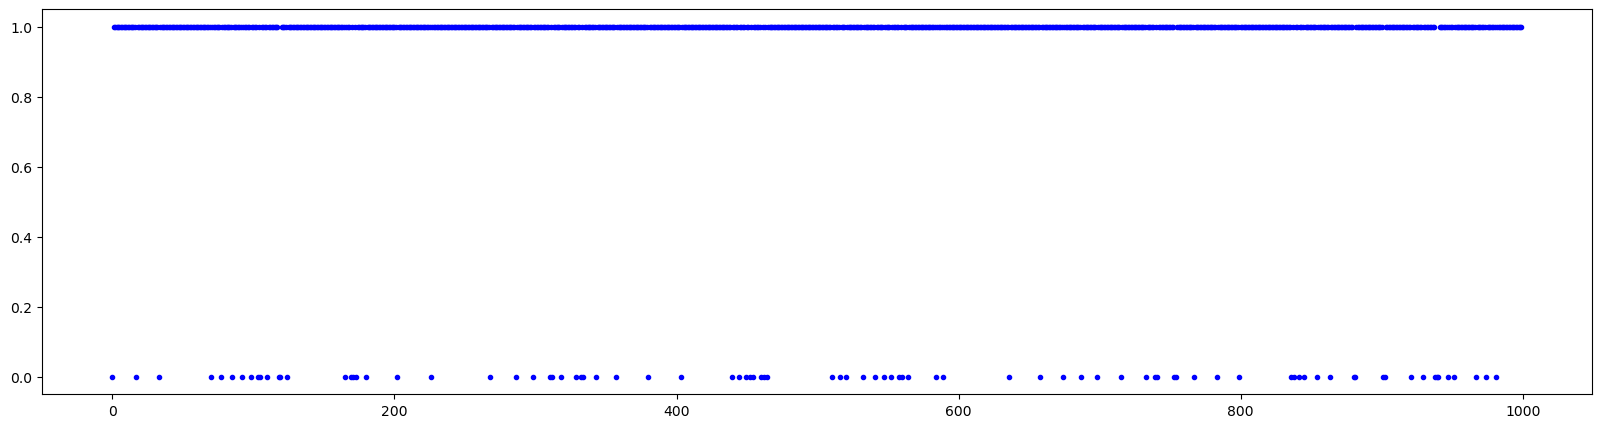

In [216]:
# plot the choice as dots
plt.figure(figsize=(20, 5))
plt.plot(range(T), choice_lst_1, 'b.', label='random')

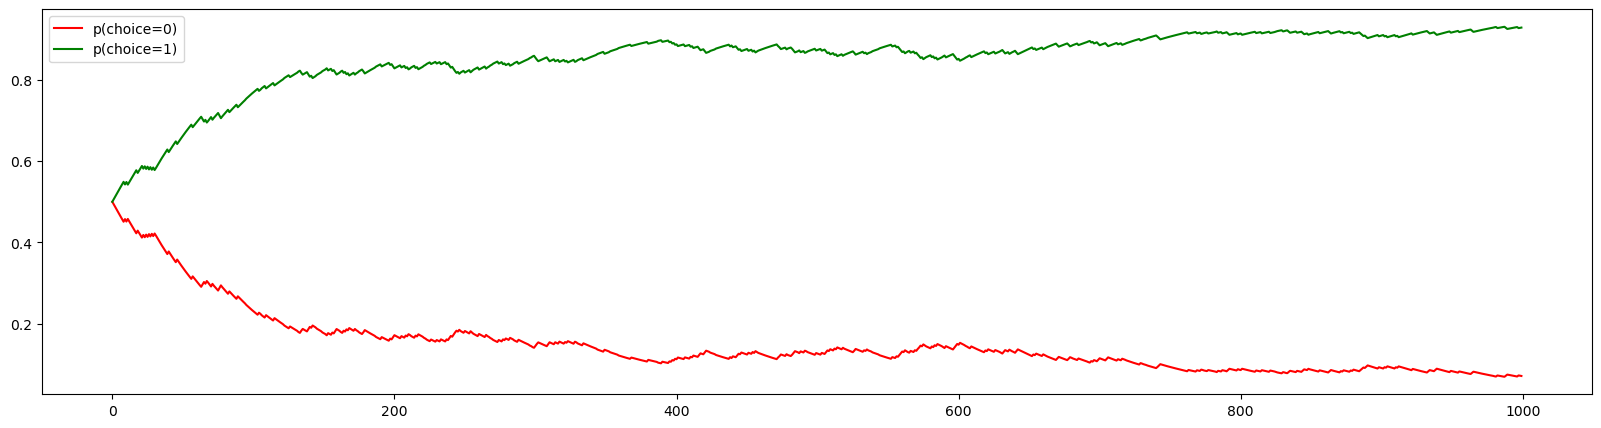

In [223]:
plt.figure(figsize=(20, 5))
plt.plot(range(T), prob_lst_2[:, 0], 'r-', label='p(choice=0)')
plt.plot(range(T), prob_lst_2[:, 1], 'g-', label='p(choice=1)')
plt.legend()

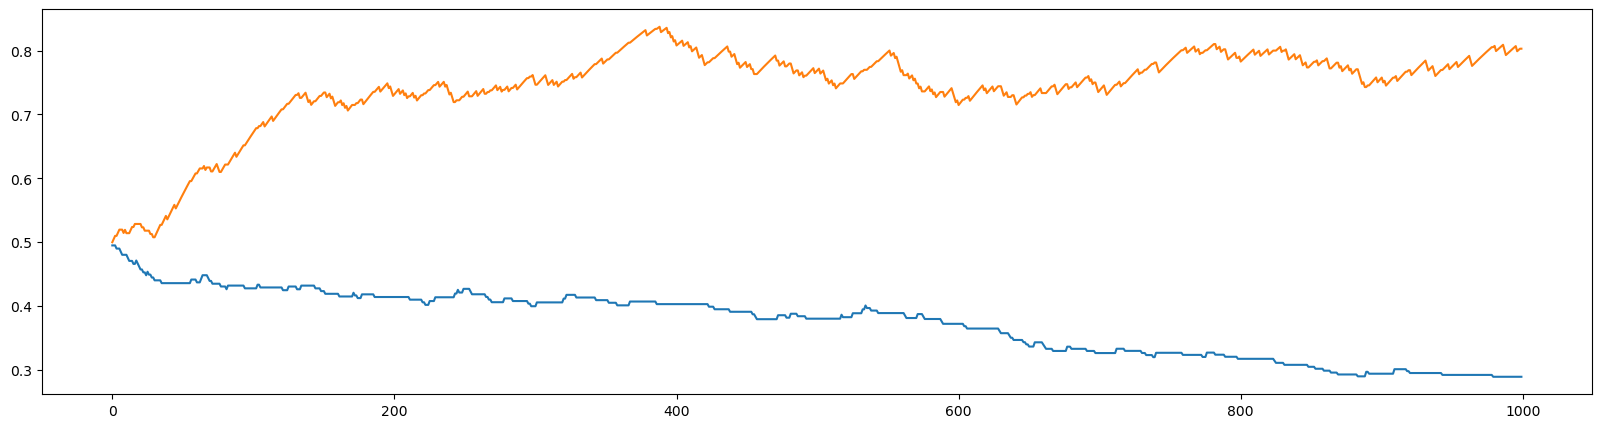

In [224]:
plt.figure(figsize=(20, 5))
plt.plot(range(T), Q_lst_2)

In [240]:
# for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]
# for beta in [0.1, 0.2, 0.3, 0.4, 0.5]
alpha_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
beta_lst = [1, 2, 5, 10, 20]
p_choice_1_all = []
for alpha in alpha_lst:
    for beta in beta_lst:
        prob_lst, choice_lst, reward_lst, Q_lst = simulation('rw', None, alpha, beta)
        p_choice_1_all.append(prob_lst[50][1])

In [241]:
p_choice_1_all = np.array(p_choice_1_all).reshape(len(alpha_lst), len(beta_lst))

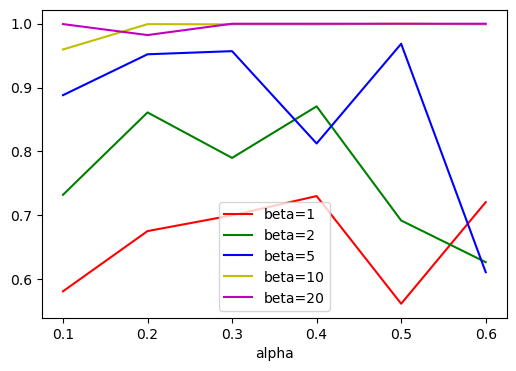

In [243]:
# plot prob_lst
plt.figure(figsize=(6, 4))
plt.plot(alpha_lst, p_choice_1_all[:, 0], 'r-', label='beta=1')
plt.plot(alpha_lst, p_choice_1_all[:, 1], 'g-', label='beta=2')
plt.plot(alpha_lst, p_choice_1_all[:, 2], 'b-', label='beta=5')
plt.plot(alpha_lst, p_choice_1_all[:, 3], 'y-', label='beta=10')
plt.plot(alpha_lst, p_choice_1_all[:, 4], 'm-', label='beta=20')
plt.legend()
plt.xticks(alpha_lst)
plt.xlabel('alpha')
plt.show()

## 5. Fit

$$ \small LogL= \sum_{t=1}^T log p(data_t|\Theta_m)=\sum_{t=1}^T logp(choice_t|\Theta_m) $$

In [ ]:
# MLE point estimate
def negLL_rw_model(alpha_beta, choice_lst, reward_lst):
    # choices and rewards are observed. choices are made already. historical data.
    # neg log likelihood -> minimize
    T = len(choice_lst)
    alpha, beta = alpha_beta
    prob_lst = np.ones((T, k))/2
    choice_prob_lst = np.ones(T)/2
    Q_lst = np.ones((T, k))/2
    for t in range(T-1):
        prob_lst[t+1], Q_lst[t+1] = rw_model(alpha, beta, reward_lst[t], Q_lst[t], choice_lst[t])
        choice_prob_lst[t+1] = prob_lst[t+1][int(choice_lst[t+1])]
    negLL = -np.sum(np.log(choice_prob_lst))
    return negLL
    

def fit_rw_model(choice_lst, reward_lst):
    # init [alpha, beta]
    x0 = [np.random.uniform(0, 1), np.random.exponential(1)]
    result = sop.minimize(fun=negLL_rw_model, x0=x0, args=(choice_lst, reward_lst),
                          bounds=[(0, 1), (0, 10)], method='trust-constr')
    return result

In [259]:
prob_lst_2, choice_lst_2, reward_lst_2, Q_lst_2 = simulation(
    'rw', None, 0.5, 5)
result_fitted = fit_rw_model(choice_lst_2, reward_lst_2)

In [260]:
print(result_fitted.x)

[0.48596622 5.55127663]


## 6. Parameter recovery

In [271]:
# prior distribution
count = 100
alpha_lst = np.random.uniform(0, 1, count)
beta_lst = np.random.exponential(3, count)

In [273]:
# parameter recovery
result_fitted_all = np.zeros((count, 2))
for cnt in range(count):
    # parameter
    alpha = alpha_lst[cnt]
    beta = beta_lst[cnt]
    # simulate behaviour
    prob_lst, choice_lst, reward_lst, Q_lst = simulation('rw', None, alpha, beta)
    # fit the model
    result_fitted = fit_rw_model(choice_lst, reward_lst)
    result_fitted_all[cnt] = result_fitted.x

/Users/w/miniconda3/envs/pomdp/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/var/folders/_z/bf4fcrv921z3rqg43pg8hc6c0000gn/T/ipykernel_93880/38816904.py:10: RuntimeWarning: overflow encountered in exp
  prob = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
/var/folders/_z/bf4fcrv921z3rqg43pg8hc6c0000gn/T/ipykernel_93880/38816904.py:10: RuntimeWarning: invalid value encountered in true_divide
  prob = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
/var/folders/_z/bf4fcrv921z3rqg43pg8hc6c0000gn/T/ipykernel_93880/349160664.py:13: RuntimeWarning: divide by zero encountered in log
  negLL = -np.sum(np.log(choice_prob_lst))


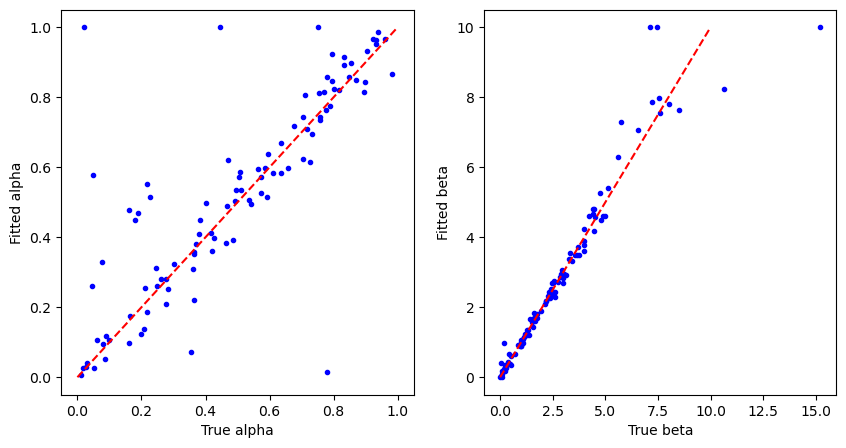

In [276]:
# plot the fitted parameters vs true parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(alpha_lst, result_fitted_all[:, 0], 'b.')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('True alpha')
ax1.set_ylabel('Fitted alpha')
ax2.plot(beta_lst, result_fitted_all[:, 1], 'b.')
ax2.plot([0, 10], [0, 10], 'r--')
# ax2.set_xlim([0, 10])
ax2.set_xlabel('True beta')
ax2.set_ylabel('Fitted beta')
plt.show()


In [281]:
# correlation
print(np.corrcoef(result_fitted_all[:, 0], alpha_lst)[1][0])
print(np.corrcoef(result_fitted_all[:, 1], beta_lst)[1][0])

0.8195873123043661
0.9556263750680049
